In [1]:
import scipy.sparse
import json
import string
import pymorphy2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm_notebook
from multiprocessing import Pool, cpu_count

In [2]:
items = pd.read_csv('../data/processed/processed_items.csv', index_col='itemId')
items.head()

,content,image,title
itemId,,,
0,согласиться дорогой любитель собака до что же ...,[-0.169 0.129 0.067 0.019 0.281 -0.245 0....,пять забавный морщинистый порода собака
1,контур три поперечный улица состоять до недавн...,[-0.158 -0.112 -0.325 0.05 -0.114 0.002 -0....,история улица ирининский в гомель
2,источник http infodays ru вообще он как то сам...,[ 0.084 -0.181 0.008 0.34 -0.03 -0.197 -0....,зачем дудь весь время спрашивать гость програм...
3,41 летний светлана зейналов решить окрестить 5...,[ 0.034 -0.119 -0.062 0.025 0.128 -0.041 0....,светлана зейналов крестить младший дочь
4,организовать преступный группировка гбао делат...,[-0.061 -0.015 -0.198 -0.047 0.054 0.029 -0....,гкнб бандит в гбао делать вид что расстаться с...


In [3]:
import gensim.models.keyedvectors as word2vec
import gc

In [4]:
path = '../data/external/ruwikiruscorpora_upos_skipgram_300_2_2019/model.bin'
w2v_model = word2vec.KeyedVectors.load_word2vec_format(path, binary=True)

In [5]:
import sys
sys.path.append('../src/features')
from w2v_stemmer import tag

In [6]:
embeddings_index = dict()
for word in tqdm_notebook(w2v_model.vocab):
    embeddings_index[word] = w2v_model[word]
print('Loaded {} word vectors.'.format(len(embeddings_index)))

gc.collect()
all_embs = np.stack(list(embeddings_index.values()))
emb_mean, emb_std = all_embs.mean(axis=0), all_embs.std(axis=0)


Loaded 248978 word vectors.


In [7]:
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/valeriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
russian_stopwords = stopwords.words("russian")

def get_embedding(label: str) -> np.ndarray:
    if isinstance(label, float):
        return np.random.normal(emb_mean, emb_std, w2v_model.vector_size)
    
    words = [word for word in label.split() if word not in russian_stopwords]
    
    if not words:
        return np.random.normal(emb_mean, emb_std, w2v_model.vector_size)
    
    label_embeddings = np.zeros((len(words), w2v_model.vector_size), dtype=np.float32)
    
    for i, word in enumerate(words):
        if word not in w2v_model:
            label_embeddings[i, :] = np.random.normal(emb_mean, emb_std, w2v_model.vector_size)
            continue
        tagged = tag(word)
        if tagged:
            label_embeddings[i, :] = w2v_model[tagged]
            continue
        label_embeddings[i, :] = np.random.normal(emb_mean, emb_std, w2v_model.vector_size)
    
    return label_embeddings.mean()
            

def get_embeddings(series: pd.Series):
    output = np.zeros((len(series), w2v_model.vector_size), dtype=np.float32)
    for i, label in tqdm_notebook(series.items(), total=len(series)):
        output[i, :] = get_embedding(label)
    return output

In [9]:
title_embeddings = get_embeddings(items['title'])
title_embeddings.shape

(328050, 300)

In [10]:
sample = pd.read_csv('../data/external/random_benchmark.csv')
sample.userId.unique().size

4349

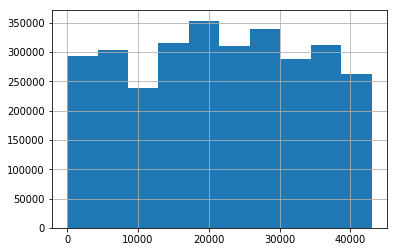

In [11]:
sample.userId.hist()
plt.show()

In [12]:
users_to_pred = sample.userId.unique()
len(users_to_pred)

4349

In [13]:
train_data = {}

train_lines = sum(1 for line in open('../data/interim/train.json','r'))

with open('../data/interim/train.json') as train_file:
    for i, line in enumerate(tqdm_notebook(train_file, total=train_lines)):
        if i in users_to_pred:
            json_line = json.loads(line)
            answers = []
            items = []
            for item, rating in json_line['trainRatings'].items():
                answers.append((-1) ** (int(rating) + 1))
                items.append(int(item))
            train_data[i] = {
                'X': items,
                'y': answers
            }

In [84]:
def learn_logistic_regression(userId, sample):
    train_items = train_data[userId]['X']
    y_train = np.array(train_data[userId]['y'])
    X_train = title_embeddings[train_items]
    model = LogisticRegression(random_state=42, C=0.01)
    model.fit(X_train, y_train)
    items_to_predict = sample[sample.userId == userId].itemId
    sample.loc[sample.userId == userId, 'pred'] = model.predict_proba(title_embeddings[items_to_predict])[:, 1]

In [85]:
sample['pred'] = np.zeros(sample.userId.shape)
sample.head()

,userId,itemId,pred
145,1,82411,0.0
32,1,48425,0.0
29,1,142561,0.0
90,1,42426,0.0
564,1,224051,0.0


In [30]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
for userId in tqdm_notebook(users_to_pred):
    learn_logistic_regression(userId, sample)

In [87]:
sample.describe()

,userId,itemId,pred
count,3.018186e+06,3.018186e+06,3.018186e+06
mean,2.151173e+04,1.632823e+05,1.667824e-01
std,1.212660e+04,9.454055e+04,8.676840e-02
min,1.000000e+00,3.000000e+00,6.406962e-02
25%,1.098700e+04,8.079000e+04,1.011650e-01
50%,2.158400e+04,1.637920e+05,1.370915e-01
75%,3.173800e+04,2.449550e+05,2.076824e-01
max,4.297500e+04,3.280490e+05,5.057063e-01


In [65]:
sample.sort_values(['userId', 'pred'], ascending=[True, False], inplace=True)
sample.drop(columns=['pred'], inplace=True)
sample.to_csv('../predictions/lin_reg_embedding_text_submission.csv', index=False)

In [66]:
import os
os.environ['KAGGLE_USERNAME'] = "klyukinv"
os.environ['KAGGLE_KEY'] = "6fc43bd58892df21aa88d9f8ad6206ef"

In [68]:
!kaggle competitions submit -c 2018-hse-ml-competition-04 -f ../predictions/lin_reg_embedding_text_submission.csv -m "Log reg title embeddings (w2v) submission №1"

100%|██████████████████████████████████████| 35.7M/35.7M [00:07<00:00, 5.08MB/s]
Successfully submitted to Рекомендательная система для статей

In [91]:
from sklearn.svm import SVC

def learn_svm(userId, sample):
    train_items = train_data[userId]['X']
    y_train = np.array(train_data[userId]['y'])
    X_train = title_embeddings[train_items]
    model = SVC(random_state=42, probability=True)
    model.fit(X_train, y_train)
    items_to_predict = sample[sample.userId == userId].itemId
    sample.loc[sample.userId == userId, 'pred'] = model.predict_proba(title_embeddings[items_to_predict])[:, 1]

In [92]:
for userId in tqdm_notebook(users_to_pred):
    learn_svm(userId, sample)

In [93]:
sample.sort_values(['userId', 'pred'], ascending=[True, False], inplace=True)
sample.drop(columns=['pred'], inplace=True)
sample.to_csv('../predictions/svm_embedding_text_submission.csv', index=False)

In [96]:
!kaggle competitions submit -c 2018-hse-ml-competition-04 -f ../predictions/svm_embedding_text_submission.csv -m "SVM title embeddings (w2v) submission"

100%|██████████████████████████████████████| 35.7M/35.7M [00:06<00:00, 5.58MB/s]
Successfully submitted to Рекомендательная система для статей